# Experimental Notebook for Simulator

## Load dataset

In [361]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import scipy as spy
import sklearn
import pandas as pd

from torch.nn.utils import rnn

from sklearn.decomposition import PCA

In [ ]:
with open("list_v2.pkl", 'rb') as f:
    data_list = pickle.load(f)

In [ ]:
data_list[0].head()

,_start,_stop,_time,APP_NAME,_measurement,ods_user,active_core_count,allocatedMemory,avgJobSize,bytes_recv,...,packets_sent,parallelism,pipelining,pmeter_end_time,pmeter_start_time,rtt,sourceType,throughput,totalBytesSent,transfer_node_name
2,2022-11-02T18:39:12.182969367Z,2022-12-02T18:39:12.182969367Z,2022-11-02T18:40:38.03Z,elvisdav@buffalo.edu-didclab-elvis-uc,transfer_data,elvisdav@buffalo.edu,96,26122125312,1073741824,44100415,...,2634,2,8,2022-11-02T18:41:01.609,2022-11-02T18:41:00.117,236.643,http,6.437433e+08,1088000000,elvisdav@buffalo.edu-didclab-elvis-uc
3,2022-11-02T18:39:12.182969367Z,2022-12-02T18:39:12.182969367Z,2022-11-02T18:41:08.025Z,elvisdav@buffalo.edu-didclab-elvis-uc,transfer_data,elvisdav@buffalo.edu,96,26122125312,1073741824,44104862,...,2634,2,8,2022-11-02T18:41:31.607,2022-11-02T18:41:30.110,238.763,http,1.018078e+09,2133225472,elvisdav@buffalo.edu-didclab-elvis-uc
4,2022-11-02T18:39:12.182969367Z,2022-12-02T18:39:12.182969367Z,2022-11-02T18:41:38.023Z,elvisdav@buffalo.edu-didclab-elvis-uc,transfer_data,elvisdav@buffalo.edu,96,26122125312,1073741824,44106572,...,2634,1,8,2022-11-02T18:42:01.599,2022-11-02T18:42:00.110,234.185,http,2.200212e+08,2419483648,elvisdav@buffalo.edu-didclab-elvis-uc
5,2022-11-02T18:39:12.182969367Z,2022-12-02T18:39:12.182969367Z,2022-11-02T18:42:08.009Z,elvisdav@buffalo.edu-didclab-elvis-uc,transfer_data,elvisdav@buffalo.edu,96,26122125312,1073741824,44112731,...,2634,1,8,2022-11-02T18:42:31.593,2022-11-02T18:42:30.113,227.423,http,2.717781e+08,1345741824,elvisdav@buffalo.edu-didclab-elvis-uc
6,2022-11-02T18:39:12.182969367Z,2022-12-02T18:39:12.182969367Z,2022-11-02T18:42:37.988Z,elvisdav@buffalo.edu-didclab-elvis-uc,transfer_data,elvisdav@buffalo.edu,96,26122125312,1073741824,44119577,...,2634,1,8,2022-11-02T18:43:01.576,2022-11-02T18:43:00.115,216.324,http,1.092180e+08,1088000000,elvisdav@buffalo.edu-didclab-elvis-uc


In [ ]:
print('Number of Sequences:', len(data_list))

Number of Sequences: 1667


## Preprocessing

### Discovery

In [ ]:
data_list[0].columns

Index(['_start', '_stop', '_time', 'APP_NAME', '_measurement', 'ods_user',
       'active_core_count', 'allocatedMemory', 'avgJobSize', 'bytes_recv',
       'bytes_sent', 'compression', 'concurrency', 'cpu_arch',
       'cpu_frequency_current', 'cpu_frequency_max', 'cpu_frequency_min',
       'destType', 'dropin', 'dropout', 'energy_consumed', 'errin', 'errout',
       'freeMemory', 'interface', 'jobId', 'jobSize', 'latency',
       'link_capacity', 'maxMemory', 'memory', 'nic_mtu', 'nic_speed',
       'packet_loss_rate', 'packets_recv', 'packets_sent', 'parallelism',
       'pipelining', 'pmeter_end_time', 'pmeter_start_time', 'rtt',
       'sourceType', 'throughput', 'totalBytesSent', 'transfer_node_name'],
      dtype='object')

In [ ]:
# data_list[0].freeMemory.dtype == np.dtype(object)
numeric_cols = [c for c in data_list[0].columns if data_list[0][c].dtype != np.dtype(object)]
print(numeric_cols)

['active_core_count', 'allocatedMemory', 'avgJobSize', 'bytes_recv', 'bytes_sent', 'compression', 'concurrency', 'cpu_frequency_current', 'cpu_frequency_max', 'cpu_frequency_min', 'dropin', 'dropout', 'energy_consumed', 'errin', 'errout', 'freeMemory', 'jobId', 'jobSize', 'latency', 'link_capacity', 'maxMemory', 'memory', 'nic_mtu', 'nic_speed', 'packet_loss_rate', 'packets_recv', 'packets_sent', 'parallelism', 'pipelining', 'rtt', 'throughput', 'totalBytesSent']


In [ ]:
numeric_data_list = [D[numeric_cols] for D in data_list]
print('Number of Sequences:', len(numeric_data_list))
# numeric_data_list[0].head()

In [ ]:
full_df = pd.concat(numeric_data_list)
test = (numeric_data_list[0] - numeric_data_list[0].mean()) / (numeric_data_list[0].std())

In [ ]:
# test.dropna(axis=1)
final_columns = list(test.dropna(axis=1))
print(final_columns)

['bytes_recv', 'bytes_sent', 'concurrency', 'cpu_frequency_current', 'freeMemory', 'latency', 'memory', 'packets_recv', 'packets_sent', 'parallelism', 'rtt', 'throughput', 'totalBytesSent']


In [ ]:
trim_list = [df[final_columns] for df in numeric_data_list]
full_df = full_df[final_columns]
final_list = [(df - full_df.mean()) / full_df.std() for df in trim_list]
final_list[0].head()

,bytes_recv,bytes_sent,concurrency,cpu_frequency_current,freeMemory,latency,memory,packets_recv,packets_sent,parallelism,rtt,throughput,totalBytesSent
2,-1.193138,-1.213334,-0.461336,0.016111,0.182852,0.605685,-0.807242,-1.193145,-1.213207,-0.639455,2.710091,-0.627423,-1.268611
3,-1.193138,-1.213334,-0.461336,-0.205508,-0.447518,0.620537,-0.012810,-1.193145,-1.213207,-0.639455,2.749202,-0.583059,-1.007988
4,-1.193138,-1.213334,-0.461336,-0.216687,-1.077883,0.621355,0.781617,-1.193145,-1.213207,-0.994308,2.664745,-0.677640,-0.936610
5,-1.193138,-1.213334,-0.461336,-0.267716,-1.508530,0.598821,1.324345,-1.193145,-1.213207,-0.994308,2.539997,-0.671506,-1.204344
6,-1.193138,-1.213334,-0.461336,0.397464,0.376316,0.604905,-1.051058,-1.193145,-1.213207,-0.994308,2.335239,-0.690772,-1.268611


In [ ]:
final_list[4].shape

(13, 13)

### PCA

In [ ]:
# PCA
combined_df = pd.concat(final_list)
# pca = PCA(n_components=8)
# pca.fit(combined_df)

In [ ]:
# combined_df.isnull().sum()
combined_df.throughput.isnull().sum()

603

In [ ]:
squeezed_list = []

for d in final_list:
    if d.throughput.isnull().sum() == 0:
        squeezed_list.append(d)


In [ ]:
final_df = pd.concat(squeezed_list)
final_df.isnull().sum()

bytes_recv               0
bytes_sent               0
concurrency              0
cpu_frequency_current    0
freeMemory               0
latency                  0
memory                   0
packets_recv             0
packets_sent             0
parallelism              0
rtt                      0
throughput               0
totalBytesSent           0
dtype: int64

In [ ]:
final_df.shape

(9032, 13)

In [ ]:
pca = PCA(n_components=6)
pca.fit(final_df)

PCA(n_components=6)

In [ ]:
reduced_list = [pca.transform(df) for df in squeezed_list]

In [ ]:
reduced_list[0]

In [ ]:
reduced_df = pca.transform(final_df)

In [ ]:
with open('pca_list_v2.pkl', 'wb') as f:
    pickle.dump(reduced_list, f)

with open('pca_combined_v2.pkl', 'wb') as f:
    pickle.dump(reduced_df, f)


In [ ]:
with open('squeezed_list_v2.pkl', 'wb') as f:
    pickle.dump(squeezed_list, f)
    
with open('squeezed_df_v2.pkl', 'wb') as f:
    pickle.dump(final_df, f)


### Splits

In [ ]:
len(reduced_list)

1313

In [ ]:
from random import shuffle

# ONCE EXECUTED; LIST IS SHUFFLED IN-PLACE
# USE PICKLE CHECKPOINT TO RESTORE reduced_list
shuffle(reduced_list)

In [ ]:
train_set = reduced_list[0:1000]
validate_set = reduced_list[1000:1020]
test_set = reduced_list[1020:]

In [ ]:
len(squeezed_list)

1313

In [ ]:
shuffle(squeezed_list)

In [ ]:
train_set = squeezed_list[0:1000]
validate_set = squeezed_list[1000:1020]
test_set = squeezed_list[1020:]

In [ ]:
test_set[0].head()

,bytes_recv,bytes_sent,concurrency,cpu_frequency_current,freeMemory,latency,memory,packets_recv,packets_sent,parallelism,rtt,throughput,totalBytesSent
10257,-0.568651,-0.554845,-1.143909,-0.329011,-1.087784,-0.233538,-1.072813,-0.568639,-0.555303,-0.994308,-0.399253,-0.391309,-1.004432
10258,-0.568575,-0.554793,-1.143909,-0.222599,-1.506309,-0.220985,-0.545361,-0.568563,-0.555251,-0.994308,0.223121,-0.079176,-1.004432
10259,-0.568491,-0.554736,-1.143909,-0.538060,-0.744114,-0.188564,-1.505928,-0.568479,-0.555194,-0.994308,0.154770,-0.654502,-1.138299
10260,-0.568417,-0.554685,-1.143909,-0.690391,-0.845078,-0.224667,-1.378687,-0.568405,-0.555144,-0.994308,-0.070854,-0.653497,-1.138299
10261,-0.568337,-0.554630,-1.143909,0.468602,-0.732931,-0.191481,-1.520022,-0.568325,-0.555089,-0.994308,0.187977,-0.654236,-1.138299


## Phase 1: FC GAN

### Classes

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
train_set[0].iloc[0]

bytes_recv              -1.193138
bytes_sent              -1.213333
concurrency              0.562524
cpu_frequency_current   -0.401619
freeMemory              -0.133230
latency                  0.594822
memory                  -0.408896
packets_recv            -1.193144
packets_sent            -1.213207
parallelism             -0.284601
rtt                      3.840350
throughput              -0.662322
totalBytesSent          -1.377126
Name: 383, dtype: float64

In [ ]:
train_set[0].iloc[0].to_numpy()

array([-1.19313827, -1.21333276,  0.56252383, -0.40161903, -0.13322958,
        0.59482239, -0.40889617, -1.1931442 , -1.2132068 , -0.28460129,
        3.84034962, -0.66232223, -1.37712594])

In [ ]:
## Pull the first state from each sequence
train_phase1 = np.array([df.iloc[0].to_numpy() for df in train_set])
validate_phase1 = np.array([df.iloc[0].to_numpy() for df in validate_set])
test_phase1 = np.array([df.iloc[0].to_numpy() for df in test_set])

In [ ]:
train_phase1.shape

(1000, 13)

In [ ]:
validate_tensor = torch.from_numpy(validate_phase1).double()# .to(device)
train_tensor = torch.from_numpy(train_phase1).double()# .to(device)
test_tensor = torch.from_numpy(test_phase1).double()# .to(device)

In [ ]:
validate_tensor[0]

tensor([-0.2069, -0.1839,  0.5625, -0.1734,  0.4675, -0.2036, -0.0630, -0.2069,
        -0.1838,  0.4251, -0.6654, -0.5901, -0.7367], dtype=torch.float64)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_size, out_size=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            nn.Linear(in_size, 13),
            nn.Tanh(),
            
            nn.Linear(13, 10),
            nn.Tanh(),
            
            nn.Linear(10, 5),
            nn.Tanh(),
            
            nn.Linear(5, 3),
            nn.Tanh(),
            
            nn.Linear(3, out_size),
            nn.Sigmoid()
        )

    def forward(self, inp):
        return self.main(inp)


In [ ]:
Discriminator(validate_tensor.shape[-1])

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=13, out_features=13, bias=True)
    (1): Tanh()
    (2): Linear(in_features=13, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=5, bias=True)
    (5): Tanh()
    (6): Linear(in_features=5, out_features=3, bias=True)
    (7): Tanh()
    (8): Linear(in_features=3, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_size, out_size):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            nn.Linear(in_size, 18),
            nn.Tanh(),
            
            nn.Linear(18, 17),
            nn.Tanh(),
            
            nn.Linear(17, 16),
            nn.Tanh(),
            
            nn.Linear(16, out_size),
        )

    def forward(self, inp):
        return self.main(inp)


### Train

In [ ]:
# Latent vector `z' size
nz = 20

netD = Discriminator(train_tensor.shape[-1]).double().to(device)
netG = Generator(nz, train_tensor.shape[-1]).double().to(device)

In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, device=device)

real_label = 1
fake_label = 0

lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 128
n_gpu = 1

# dataloader = DataLoader(train_tensor, batch_size=batch_size,
#                        num_workers=4*n_gpu, pin_memory=True)

class DataIterator:
    def __init__(self, dataset, batch_size, max_samples):
        self.dataset = dataset
        self.batch_size = batch_size
        self.max_samples = max_samples
        self.n = 0
        self._len = dataset.shape[0]
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __len__(self):
        return self.max_samples
    
    def __next__(self):
        if self.n <= self.max_samples:
            # get and return samples
            indices = np.random.choice(np.arange(self._len), self.batch_size, replace=False)
            indices.sort()
            self.n += 1
            return self.dataset[indices]
        else:
            raise StopIteration

In [ ]:
G_losses = []
D_losses = []
iters = 0

num_epochs = 7

state_list = []
fixed_noise_doub = fixed_noise.double()

print("Starting Training Loop...")
# For each epoch
dataloader = DataIterator(train_tensor, batch_size, 10000)

for epoch in range(num_epochs):
    # For each batch from training dataset
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        
        label = torch.full((batch_size, ), real_label, dtype=torch.double, device=device)
        # if i % 20 == 0:
        netD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)

        label = torch.full((b_size, ), real_label, dtype=torch.double, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
            # D_x = -1.
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device).double()
        # Generate fake start state batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        
        # if i % 20 == 0:
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        # added to previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # D_G_z1 = -1.
        # Compute error of D as sum over the fake and the
        # real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        if i % 4 != 0:
            continue
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) # fake labels are real for generator cost
        # perform another forward pass of fake-batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # D_G_z2 = -1.
        
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # append losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how generator is doing by saving G's output
#         if (iters % 500 == 0) or ((epoch == num_epochs-1) and
#                                  (i == len(dataloader)-1)):
#             with torch.no_grad():
#                 fake = netG(fixed_noise_doub).detach().cpu()
#             state_list.append(fake)
        
        iters += 1


Starting Training Loop...
[0/7][0/10000]	Loss_D: 1.3940	Loss_G: 0.7619	D(x): 0.4654	D(G(z)): 0.4668 / 0.4668
[0/7][500/10000]	Loss_D: 1.1498	Loss_G: 0.9562	D(x): 0.5521	D(G(z)): 0.3903 / 0.3888
[0/7][1000/10000]	Loss_D: 1.0227	Loss_G: 1.1545	D(x): 0.5767	D(G(z)): 0.3166 / 0.3163
[0/7][1500/10000]	Loss_D: 0.4962	Loss_G: 1.6125	D(x): 0.8156	D(G(z)): 0.2086 / 0.2078
[0/7][2000/10000]	Loss_D: 0.4631	Loss_G: 1.7826	D(x): 0.8275	D(G(z)): 0.1822 / 0.1801
[0/7][2500/10000]	Loss_D: 0.6276	Loss_G: 1.8202	D(x): 0.7610	D(G(z)): 0.1766 / 0.1743
[0/7][3000/10000]	Loss_D: 0.6739	Loss_G: 1.7147	D(x): 0.7586	D(G(z)): 0.1967 / 0.1949
[0/7][3500/10000]	Loss_D: 0.3777	Loss_G: 1.9863	D(x): 0.8671	D(G(z)): 0.1495 / 0.1465
[0/7][4000/10000]	Loss_D: 0.5358	Loss_G: 2.1522	D(x): 0.8230	D(G(z)): 0.1283 / 0.1267
[0/7][4500/10000]	Loss_D: 0.6270	Loss_G: 2.1435	D(x): 0.7891	D(G(z)): 0.1273 / 0.1271
[0/7][5000/10000]	Loss_D: 0.4890	Loss_G: 2.3326	D(x): 0.8572	D(G(z)): 0.1168 / 0.1165
[0/7][5500/10000]	Loss_D: 0.5424

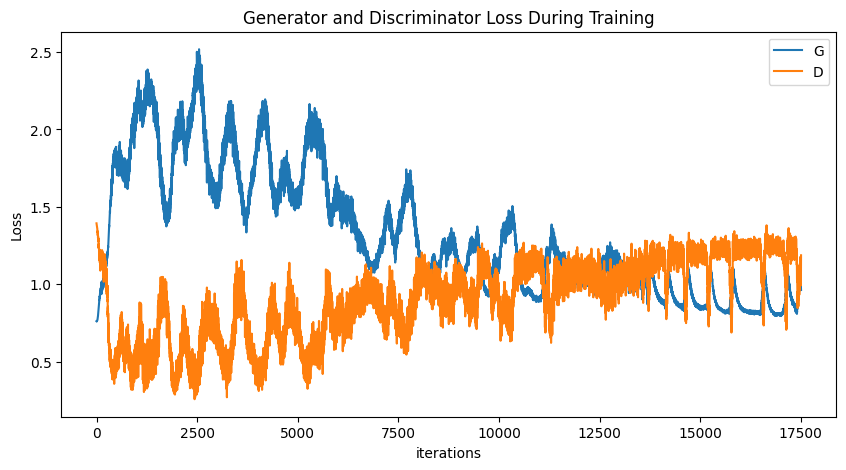

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("phase1_gan.png")
plt.show()

In [ ]:
with torch.no_grad():
    test = netG(fixed_noise.double()[:2])
    test_truth = netD(test)
    
    print(test)
    print(test_truth)

# test_df = pd.DataFrame(data=test.cpu().numpy(), columns=final_df.columns)
# final_df[:2]

tensor([[ 0.9425,  1.5246,  0.8545, -0.4205, -0.0994, -0.3232, -0.3216,  1.3177,
          1.1614,  0.0021, -0.7887, -0.2403,  0.5203],
        [ 0.7892,  0.6334,  0.3159, -0.5097,  1.3117, -0.2423, -0.9948,  1.0167,
          0.3572, -0.1104, -0.2955, -0.0803, -0.2347]], device='cuda:0',
       dtype=torch.float64)
tensor([[0.3832],
        [0.4237]], device='cuda:0', dtype=torch.float64)


In [ ]:
final_df.columns

Index(['bytes_recv', 'bytes_sent', 'concurrency', 'cpu_frequency_current',
       'freeMemory', 'latency', 'memory', 'packets_recv', 'packets_sent',
       'parallelism', 'rtt', 'throughput', 'totalBytesSent'],
      dtype='object')

### Test

In [ ]:
### See how discriminator performs

cuda_test_tensor = test_tensor.double().to(device)

with torch.no_grad():
    disc_test = netD(cuda_test_tensor)

torch.mean(disc_test)

tensor(0.5695, device='cuda:0', dtype=torch.float64)

In [ ]:
cuda_train_tensor = train_tensor.double().to(device)

with torch.no_grad():
    disc_test_2 = netD(cuda_train_tensor)
    
torch.mean(disc_test_2)

tensor(0.5934, device='cuda:0', dtype=torch.float64)

## Phase 2: LSTM->FC GAN

### Classes

In [ ]:
device

'cuda'

In [ ]:
## Convert dataframes to tensors
train_phase2 = [torch.from_numpy(df.to_numpy()).double()
                for df in train_set]

validate_phase2 = [torch.from_numpy(df.to_numpy()).double()
                   for df in validate_set]

test_phase2 = [torch.from_numpy(df.to_numpy()).double()
               for df in test_set]


In [377]:
# Try Stacked RNNs
class BigDiscriminator(nn.Module):
    def __init__(self, in_size, out_size=1, batch_first=False):
        super(BigDiscriminator, self).__init__()
        # Stacked GRU - 2 Layers
        self.GRU = nn.GRU(in_size, in_size, 2, batch_first=batch_first)
        
        self.FC = nn.Sequential(
            
            nn.Linear(in_size, 13),
            nn.Tanh(),
            
            nn.Linear(13, 10),
            nn.Tanh(),
            
            nn.Linear(10, 5),
            nn.Tanh(),
            
            nn.Linear(5, 3),
            nn.Tanh(),
            
            nn.Linear(3, out_size),
            nn.Sigmoid()
        )

    def forward(self, inp, h0):
        outputs, _ = self.GRU(inp, h0)
        return self.FC(outputs[-1])


In [350]:
testBD = BigDiscriminator(10)

test_input = torch.randn(4, 10)
test_h0 = torch.randn(2, 10)

with torch.no_grad():
    output = testBD(test_input, test_h0)
print(output)

tensor([0.5907])


In [ ]:
test_input

tensor([[ 0.0733,  0.0374,  1.2083, -0.7925,  0.2725,  1.2226,  1.2073, -3.6517,
          0.4342,  0.6878],
        [ 0.5287, -1.3232,  0.6916,  0.7068, -0.8435,  1.5884,  0.4511,  1.2193,
          0.2776,  1.0604],
        [ 1.8943,  1.6150,  1.4278,  0.4761, -0.9244, -1.4450, -0.2795,  0.7001,
          0.5387, -1.5808],
        [ 2.8133, -0.6235,  0.2511, -0.5107, -0.2686, -1.0610,  0.0094, -0.8849,
          0.9055,  0.0369]])

In [351]:
# Try Stacked RNNs
class BigGenerator(nn.Module):
    def __init__(self, in_size, out_size, 
                 stack_size=3, init_cell_state=None,
                batch_first=False):
        super(BigGenerator, self).__init__()
        self.LSTM = nn.LSTM(in_size, out_size, stack_size,
                           batch_first=batch_first)
        if init_cell_state is None:
            self.c0 = torch.zeros(stack_size, out_size).float()
        else:
            self.c0 = init_cell_state
        
    def forward(self, inp, h0):
        outputs, _ = self.LSTM(inp, (h0, self.c0))
        return outputs
    
    def next_state(self, action, state_in, c_in):
        with torch.no_grad():
            outputs, _ = self.LSTM(action, (state_in, c_in))
            return outputs


In [355]:
print(testBG)

BigGenerator(
  (LSTM): LSTM(2, 13, num_layers=3)
)


### Train

In [493]:
with torch.no_grad():
    test_h0 = netG(fixed_noise[0].double())

test_h0 = test_h0.cpu()

In [ ]:
test_h0.repeat(3, 1)

In [495]:
test_c0 = torch.zeros(3, 4, 13).float()
testBG = BigGenerator(2, 13, init_cell_state=test_c0)
test_actions = torch.randint(-1, 2, (5, 4, 2)).float()

test_H = test_h0.repeat(3, 4, 1).float()

with torch.no_grad():
    outputs = testBG(test_actions, test_H)
print(outputs.shape)
print(outputs)

torch.Size([5, 4, 13])
tensor([[[ 6.5830e-02, -3.8858e-02, -6.0844e-02,  4.2846e-02, -4.7745e-02,
           1.8838e-01, -3.0601e-02,  4.4892e-02,  1.3539e-01, -1.3884e-01,
           1.5241e-01,  1.5447e-01, -2.9597e-02],
         [ 6.4060e-02, -3.9290e-02, -6.1063e-02,  4.2847e-02, -4.8327e-02,
           1.8851e-01, -3.1217e-02,  4.4020e-02,  1.3615e-01, -1.3994e-01,
           1.5288e-01,  1.5431e-01, -2.9150e-02],
         [ 6.6583e-02, -3.8596e-02, -6.0935e-02,  4.2808e-02, -4.7799e-02,
           1.8852e-01, -3.0406e-02,  4.5143e-02,  1.3503e-01, -1.3839e-01,
           1.5257e-01,  1.5452e-01, -2.9793e-02],
         [ 6.6583e-02, -3.8596e-02, -6.0935e-02,  4.2808e-02, -4.7799e-02,
           1.8852e-01, -3.0406e-02,  4.5143e-02,  1.3503e-01, -1.3839e-01,
           1.5257e-01,  1.5452e-01, -2.9793e-02]],

        [[ 2.7253e-02, -4.1552e-02, -4.9704e-02,  5.4072e-02, -7.3426e-02,
           8.3302e-02, -1.0499e-02, -2.3674e-02,  9.1862e-02,  8.4675e-03,
           1.2539e-01,  4

In [ ]:
validate_phase2[0]

In [366]:
_ = rnn.pad_sequence(validate_phase2, batch_first=True)

In [411]:
testBD = BigDiscriminator(13, batch_first=False)

test_h0 = torch.zeros(2, 3, 13).float()
test_input = rnn.pad_sequence(validate_phase2[:3], batch_first=False).float()

print(test_input.dtype)
print(test_h0.dtype)

with torch.no_grad():
    output = testBD(test_input, test_h0)

print(output.view(-1))

torch.float32
torch.float32
tensor([0.4260, 0.4240, 0.4264])


In [388]:
torch.save(netG.state_dict(), 'netG.model')

In [386]:
train_tensor = rnn.pad_sequence(train_phase2, batch_first=False)
print(train_tensor.shape)

torch.Size([32, 1000, 13])


In [389]:
train_tensor = train_tensor.float()
print(train_tensor.dtype)
print(train_tensor.shape[0])

torch.float32
32


In [478]:
batch_size = 128
n_gpu = 1

# dataloader = DataLoader(train_tensor, batch_size=batch_size,
#                        num_workers=4*n_gpu, pin_memory=True)

class DataIterator2:
    def __init__(self, dataset, batch_size, max_samples):
        self.dataset = dataset
        self.batch_size = batch_size
        self.max_samples = max_samples
        self.n = 0
        self._len = dataset.shape[1]
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __len__(self):
        return self.max_samples
    
    def __next__(self):
        if self.n <= self.max_samples:
            # get and return samples
            indices = np.random.choice(np.arange(self._len), self.batch_size, replace=False)
            indices.sort()
            self.n += 1
            return self.dataset[:, indices, :]
        else:
            raise StopIteration

In [496]:
# Sequence length is 32 from previous cell
seq_len = train_tensor.shape[0]
action_size = 2
gen_stack_size = 3

zero_c0 = torch.zeros(3, batch_size, 13, device=device).float()

netBD = BigDiscriminator(train_tensor.shape[-1]).to(device)
netBG = BigGenerator(action_size, train_tensor.shape[-1], init_cell_state=zero_c0).to(device)

In [497]:
criterion = nn.BCELoss()

# fixed_noise = torch.randn(64, nz, device=device)

real_label = 1
fake_label = 0

lr = 0.0002
beta1 = 0.5

zero_h0 = torch.zeros(2, batch_size, 13, device=device).float()

optimizerBD = optim.Adam(netBD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerBG = optim.Adam(netBG.parameters(), lr=lr, betas=(beta1, 0.999))

In [408]:
noise = torch.randn(b_size, nz, device=device).double()
print(noise.shape)
print(netG)
# Generate fake start state batch with G
with torch.no_grad():
    fake_start = netG(noise)
    
fake_start.repeat(3, 1, 1).shape

torch.Size([128, 20])
Generator(
  (main): Sequential(
    (0): Linear(in_features=20, out_features=18, bias=True)
    (1): Tanh()
    (2): Linear(in_features=18, out_features=17, bias=True)
    (3): Tanh()
    (4): Linear(in_features=17, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=13, bias=True)
  )
)


torch.Size([3, 128, 13])

In [498]:
G_losses = []
D_losses = []
iters = 0

num_epochs = 4

state_list = []
fixed_noise_doub = fixed_noise.double()

print("Starting Training Loop...")
# For each epoch
dataloader = DataIterator2(train_tensor, batch_size, 10000)

intensity_switch = False
focus = 5

for epoch in range(num_epochs):
    # For each batch from training dataset
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        
        label = torch.full((batch_size, ), real_label, dtype=torch.float, device=device)
        # if i % 20 == 0:
        netBD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)

        # Forward pass real batch through D
        output = netBD(real_cpu, zero_h0).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
            # D_x = -1.
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, nz, device=device).double()
        with torch.no_grad():
            fake_start = netG(noise).float()
            fake_start = fake_start.repeat(gen_stack_size, 1, 1)
        
        fake_actions = torch.randint(-1, 2, (10, batch_size, action_size), device=device).float()
        fake_states = netBG(fake_actions, fake_start)
        
        
        # Generate fake start state batch with G
        label.fill_(fake_label)
        
        # if i % 20 == 0:
        # Classify all fake batch with D
        output = netBD(fake_states.detach(), zero_h0).view(-1)
        
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        # added to previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # D_G_z1 = -1.
        # Compute error of D as sum over the fake and the
        # real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerBD.step()
        
#         for _ in range(3):
#             netBD.zero_grad()
#             noise = torch.randn(b_size, nz, device=device).double()
#             # Generate fake start state batch with G
#             with torch.no_grad():
#                 fake_start = netG(noise).float()
#                 fake_start = fake_start.repeat(gen_stack_size, 1, 1)
            
#             fake_actions = torch.randint(-1, 2, (seq_len, b_size, action_size), device=device).float()
            
#             fake_states = netBG(fake_actions, fake_start)
#             # label.fill_(fake_label)

#             # if i % 20 == 0:
#             # Classify all fake batch with D
#             output = netBD(fake_states.detach(), zero_h0).view(-1)
#             errD_fake = criterion(output, label)
#             # Calculate D's loss on the all-fake batch
#             errD_fake = criterion(output, label)
#             # Calculate the gradients for this batch
#             # added to previous gradients
#             errD_fake.backward()
            
#             # Update D
#             optimizerBD.step()
        
        # if i % 4 != 0:
        #     continue
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netBG.zero_grad()
        label.fill_(real_label) # fake labels are real for generator cost
        # perform another forward pass of fake-batch through D
        output = netBD(fake_states, zero_h0).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerBG.step()
        
        if D_G_z2 < 0.3 and not intensity_switch:
            print('[!!!] Intensifying training...')
            intensity_switch = True
            focus = 150
        elif D_G_z2 > 0.5 and intensity_switch:
            print('[!!!] Relaxing training...')
            intensity_switch = False
            focus = 5
        
        for _ in range(focus):
            netBG.zero_grad()
            
            noise = torch.randn(batch_size, nz, device=device).double()
            with torch.no_grad():
                fake_start = netG(noise).float()
                fake_start = fake_start.repeat(gen_stack_size, 1, 1)

            fake_actions = torch.randint(-1, 2, (10, batch_size, action_size), device=device).float()
            fake_states = netBG(fake_actions, fake_start)
            
            # perform another forward pass of fake-batch through D
            output = netBD(fake_states, zero_h0).view(-1)
            # Calculate G's loss based on this output
            errG2 = criterion(output, label)
            # Calculate gradients for G
            errG2.backward()
            
            # Update G
            optimizerBG.step()
        
        # D_G_z2 = -1.
        
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # append losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how generator is doing by saving G's output
#         if (iters % 500 == 0) or ((epoch == num_epochs-1) and
#                                  (i == len(dataloader)-1)):
#             with torch.no_grad():
#                 fake = netG(fixed_noise_doub).detach().cpu()
#             state_list.append(fake)
        
        iters += 1


Starting Training Loop...
[0/4][0/10000]	Loss_D: 1.4087	Loss_G: 0.5560	D(x): 0.5737	D(G(z)): 0.5739 / 0.5735
[0/4][500/10000]	Loss_D: 1.3868	Loss_G: 0.6871	D(x): 0.5030	D(G(z)): 0.5032 / 0.5031
[!!!] Intensifying training...
[0/4][1000/10000]	Loss_D: 0.5275	Loss_G: 1.3039	D(x): 0.8104	D(G(z)): 0.2719 / 0.2715
[0/4][1500/10000]	Loss_D: 0.3196	Loss_G: 1.7747	D(x): 0.8748	D(G(z)): 0.1697 / 0.1695
[0/4][2000/10000]	Loss_D: 0.2333	Loss_G: 2.0936	D(x): 0.9033	D(G(z)): 0.1233 / 0.1232


KeyboardInterrupt: 

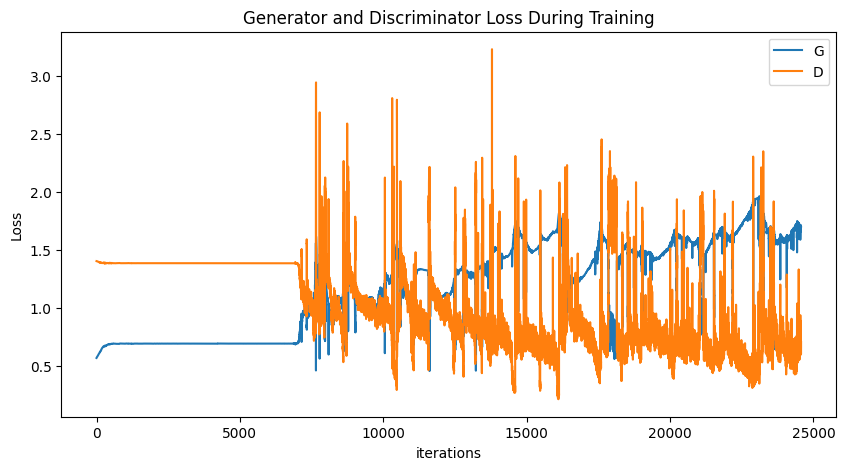

In [490]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("phase2_gan.png")
plt.show()

In [491]:
with torch.no_grad():
    start_state = netG(fixed_noise.double()[0]).float()
    fake_actions = torch.randint(-1, 2, (3, 2)).float()
    
    outputs, _ = netBG(fake_actions, start_state)

print(outputs)

RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (1-D, 3-D) tensors